In [37]:
# libraries
import pandas as pd
import requests
import spacy

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Data Collection

In [ ]:
# open files

start_date = 16
year_month = '202307'

df = pd.DataFrame()
col_names = ['GLOBALEVENTID', 'IsRootEvent','AvgTone','Actor1Code','Actor1Name','Actor1CountryCode','Actor1Type1Code','Actor2Code','Actor2Name','Actor2CountryCode','Actor2Type1Code','EventCode','EventBaseCode','EventRootCode','SOURCEURL']

# read files from 16 July 2023 to 31 July 2023
for dt in range(16,32):
    if dt == 20:
        continue
    file_name = year_month + str(dt) + '.csv'
    df_temp = pd.read_csv(file_name, usecols=col_names, dtype=str)
    df = pd.concat([df, df_temp])
    print(dt, len(df))

In [41]:
print('Number of records:', len(df))
list(df.columns)

Number of records: 1909742


['GLOBALEVENTID',
 'Actor1Code',
 'Actor1Name',
 'Actor1CountryCode',
 'Actor1Type1Code',
 'Actor2Code',
 'Actor2Name',
 'Actor2CountryCode',
 'Actor2Type1Code',
 'IsRootEvent',
 'EventCode',
 'EventBaseCode',
 'EventRootCode',
 'AvgTone',
 'SOURCEURL']

#### Extract only refugee related events from GDELT

In [42]:
# find articles with refugee in source url
df = df[df["SOURCEURL"].str.contains(r'refugee')]
print('Data with source url with refugee word', len(df))

# remove duplicates
df.drop_duplicates('SOURCEURL', inplace = True)

# remove non root source
df = df[df.IsRootEvent == '1']
print('Data with root event', len(df))

# save to the file
df.to_csv('gdelt_refugee.csv', index=False)

Data with source url with refugee word 6226
Data with root event 527


### Extract news content

#### Load refugee data

In [5]:
df = pd.read_csv('gdelt_refugee.csv')
print(len(df))

Note: For prototype, we only use data from these 3 sources because in order to extract the news content, we need to customise each URL

In [32]:
news_source = ['winnipeg.ctvnews.ca', 'www.jordantimes.com', 'nowtoronto.com']
news_source_pattern = '|'.join(news_source)

df = df[df["SOURCEURL"].str.contains(news_source_pattern)]
print(len(df))

9


##### Access the HTML content with requests library

In [48]:
def get_news_content(URL, class_div):
    remove_words = ['<div class="c-text">', '<p>', '</p>', '</div>', '\r','\n','\t']

    r = requests.get(URL)
    
    soup = BeautifulSoup(r.content)
    
    content_text = soup.find('div', attrs = {'class':class_div})  # return bs4.element.Tag

    p = content_text.find_all('p')
    paragraphs = []
    for x in p:
        paragraphs.append(str(x))

    texts = ' '.join(paragraphs)

    # Clean up text

    for remove_word in remove_words:
        texts = texts.replace(remove_word, '')
        
    return texts

#### Extract news content from source url and save to a file

In [49]:
content_df = pd.DataFrame(columns=['global_id', 'news_content'])

for index, row in df.iterrows():
    global_id = row['GLOBALEVENTID']
    url = row['SOURCEURL']

    if 'winnipeg.ctvnews.ca' in url:
        class_div = 'c-text'
      
    if 'nowtoronto.com' in url:
        class_div = 'nt-post__post-content nt-post-standard__post-content'

    if 'jordantimes.com' in url:
        class_div = 'news-body'

    news_content = get_news_content(url, class_div)
    
    # append content to content data 
    content_df.loc[len(content_df)] = {'global_id':global_id, 'news_content':news_content}

# save content to a file
content_df.to_csv('gdelt_refugee_news.csv', index=False)
print(len(content_df))

9


### Machine Learning - Topic Modelling

#### Load data

In [4]:
content_df = pd.read_csv('gdelt_refugee_news.csv')
print(len(content_df))

documents = []

for index, row in content_df.iterrows():
    documents.append(row['news_content'])

9


#### Vectorization

Vectorization is a part of feature extraction. The objective is to get distinct features by converting text to numerical vectors

In [6]:
vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
tf = vectorizer.fit_transform(documents)

n_topics = 3

In [15]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(documents, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[documents], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(documents)  # processed Text Data!

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.031*"refugee" + 0.014*"shelter" + 0.012*"housing" + 0.012*"space" + 0.010*"city" + 0.010*"community" + 0.008*"street" + 0.008*"asylum" + 0.008*"crisis" + 0.008*"help"'), (1, '0.021*"ukrainian" + 0.016*"people" + 0.014*"agency" + 0.014*"festival" + 0.013*"job" + 0.011*"year" + 0.011*"speak" + 0.011*"myrowich" + 0.009*"staff" + 0.009*"music"'), (2, '0.020*"refugee" + 0.017*"palestinian" + 0.015*"camp" + 0.011*"lebanese" + 0.009*"target" + 0.009*"noopener" + 0.009*"government" + 0.009*"noreferrer" + 0.008*"include" + 0.008*"twitter"'), (3, '0.041*"refugee" + 0.021*"food" + 0.019*"cent" + 0.014*"assistance" + 0.014*"community" + 0.012*"camp" + 0.011*"report" + 0.011*"syrian" + 0.009*"remain" + 0.009*"woman"')]


In [24]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=documents):
    # Init output
    sent_topics_df = pd.DataFrame(columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.loc[len(sent_topics_df)] = [int(topic_num), round(prop_topic,4), topic_keywords]
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.9968,"ukrainian, people, agency, festival, job, year...","[war, ukraine, pass, day, staffing, continue, ..."
1,1,2,0.9962,"refugee, palestinian, camp, lebanese, target, ...","[confirm, federal, government, allot, addition..."
2,2,3,0.9934,"refugee, food, cent, assistance, community, ca...","[emirate, red, crescent, cooperation, jordania..."
3,3,0,0.9944,"refugee, shelter, housing, space, city, commun...","[begin, day, tour, mean, grow, mutually, benef..."
4,4,1,0.9950,"ukrainian, people, agency, festival, job, year...","[festival, offer, free, ticket, ukrainian, set..."
5,5,0,0.9962,"refugee, shelter, housing, space, city, commun...","[headway, secure, much, shelter, space, refuge..."
6,6,3,0.9962,"refugee, food, cent, assistance, community, ca...","[average, amount, debt, refugee, camp, host, c..."
7,7,2,0.9956,"refugee, palestinian, camp, lebanese, target, ...","[least, people, kill, clash, palestinian, sour..."
8,8,3,0.9907,"refugee, food, cent, assistance, community, ca...","[visit, syrian, family, community, centre, gov..."


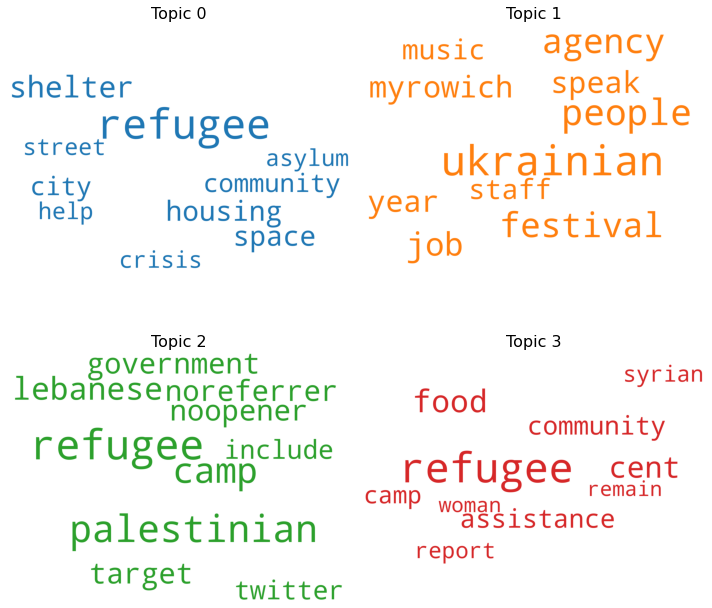

In [25]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [26]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.098916 -0.102746       1        1  26.612942
1     -0.162037 -0.043547       2        1  25.805322
2      0.015772  0.120964       3        1  25.066736
0      0.047349  0.025328       4        1  22.515001, topic_info=            Term      Freq     Total Category  logprob  loglift
133    ukrainian  8.000000  8.000000  Default  30.0000  30.0000
19          cent  8.000000  8.000000  Default  29.0000  29.0000
700  palestinian  6.000000  6.000000  Default  28.0000  28.0000
3         agency  6.000000  6.000000  Default  27.0000  27.0000
460     festival  6.000000  6.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
195   government  2.107596  7.296955   Topic4  -5.0693   0.2491
144         year  2.071825  7.976965   Topic4  -5.0864   0.1429
235         read  1.456754  2.622771   Topic4  -5.4387   0.9030
182   experience  1.460186  3.292417   Topic4  -5.4363   0.6779
220   noreferrer  1.470473  6.645694   Topic4  -5.4293  -0.0174

[215 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.995135        able
271       1  0.989204      accord
146       3  0.498837    activist
148       3  0.498851  additional
3         2  0.992890      agency
...     ...       ...         ...
352       4  0.186470       woman
144       1  0.125361        year
144       2  0.501444        year
144       3  0.125361        year
144       4  0.250722        year

[255 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

### Experiment with BERT - Deep Learning

In [ ]:
from bertopic import BERTopic
from hdbscan import HDBSCAN

In [29]:
hdbscan_model = HDBSCAN(min_topic_size=5, metric='euclidean', prediction_data=True)

In [35]:
model = BERTopic(min_topic_size=9)
topics, probs = model.fit_transform(documents)

In [36]:
model.get_topic_freq()

,Topic,Count
0,-1,9


In [33]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9,-1_the_to_and_of,"[the, to, and, of, in, for, refugees, on, with...",[Immigration Minister Sean Fraser confirmed on...


### References
- https://www.projectpro.io/article/topic-modeling-nlp/801
- https://omdena.com/blog/latent-dirichlet-allocation/  
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#14.-pyLDAVis
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- https://www.linkedin.com/advice/1/how-do-you-evaluate-coherence-perplexity#:~:text=One%20way%20to%20evaluate%20your,of%20topics%20for%20your%20data.
- https://deepgram.com/learn/python-topic-modeling-with-a-bert-model